## Sentiment-enhanced drug recommendation system

In [1]:
#Importing the neccesary libraries
seed = 123
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#sns.set(style="whitegrid", context='talk')
import warnings                                 
warnings.filterwarnings('ignore')

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

## Loading the dataset

In [2]:
#Loading the train and test dataset
train_dataset=pd.read_csv('drugLibTrain_raw.tsv',sep='\t')
test_dataset=pd.read_csv('drugLibTest_raw.tsv',sep='\t')

In [3]:
train_dataset.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [4]:
test_dataset.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,1366,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,The antibiotic may have destroyed bacteria cau...,"Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infect...
1,3724,lamictal,9,Highly Effective,Mild Side Effects,bipolar disorder,Lamictal stabilized my serious mood swings. On...,"Drowsiness, a bit of mental numbness. If you t...",Severe mood swings between hypomania and depre...
2,3824,depakene,4,Moderately Effective,Severe Side Effects,bipolar disorder,Initial benefits were comparable to the brand ...,"Depakene has a very thin coating, which caused...",Depakote was prescribed to me by a Kaiser psyc...
3,969,sarafem,10,Highly Effective,No Side Effects,bi-polar / anxiety,It controlls my mood swings. It helps me think...,I didnt really notice any side effects.,This drug may not be for everyone but its wond...
4,696,accutane,10,Highly Effective,Mild Side Effects,nodular acne,Within one week of treatment superficial acne ...,Side effects included moderate to severe dry s...,Drug was taken in gelatin tablet at 0.5 mg per...


In [5]:
train_dataset.shape[0],train_dataset['Unnamed: 0'].nunique()

(3107, 3107)

In [6]:
test_dataset.shape[0],test_dataset['Unnamed: 0'].nunique()

(1036, 1036)

In [7]:
tr_unique_ID_list=train_dataset['Unnamed: 0'].unique().tolist()

In [8]:
len(tr_unique_ID_list)

3107

In [9]:
ts_unique_ID_list=test_dataset['Unnamed: 0'].unique().tolist()

In [10]:
len(ts_unique_ID_list)

1036

In [11]:
common_ID_list=[i for i in ts_unique_ID_list if i in tr_unique_ID_list]

In [12]:
len(common_ID_list)

0

In [13]:
data_set = pd.concat([train_dataset,test_dataset])

In [14]:
data_set.shape

(4143, 9)

In [15]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4143 entries, 0 to 1035
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4143 non-null   int64 
 1   urlDrugName        4143 non-null   object
 2   rating             4143 non-null   int64 
 3   effectiveness      4143 non-null   object
 4   sideEffects        4143 non-null   object
 5   condition          4142 non-null   object
 6   benefitsReview     4143 non-null   object
 7   sideEffectsReview  4141 non-null   object
 8   commentsReview     4135 non-null   object
dtypes: int64(2), object(7)
memory usage: 323.7+ KB


In [16]:
data_set.any().isnull().sum()

0

In [17]:
data_set.dropna(axis=0, inplace=True)

In [18]:
data_set.isnull().any().sum()

0

## EXPLORATORY DATA ANALYSIS

In [19]:
data_set.head(1)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."


In [20]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4132 entries, 0 to 1035
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4132 non-null   int64 
 1   urlDrugName        4132 non-null   object
 2   rating             4132 non-null   int64 
 3   effectiveness      4132 non-null   object
 4   sideEffects        4132 non-null   object
 5   condition          4132 non-null   object
 6   benefitsReview     4132 non-null   object
 7   sideEffectsReview  4132 non-null   object
 8   commentsReview     4132 non-null   object
dtypes: int64(2), object(7)
memory usage: 322.8+ KB


In [21]:
# Finding number of unique drugs
data_set['urlDrugName'].nunique()

540

In [22]:
# Finding number of unique health conditions
data_set['condition'].nunique()

1804

#### What are the different types of drugs and how many records are there for each drug?

In [23]:
drug_count=data_set.groupby('urlDrugName').size().sort_values(ascending=False).to_frame().reset_index().rename(columns={'urlDrugName':'Drug Name',0:'Number of Records for drugs'})

In [24]:
drug_count

,Drug Name,Number of Records for drugs
0,lexapro,74
1,paxil,58
2,retin-a,55
3,synthroid,53
4,zoloft,52
...,...,...
535,patanol,1
536,carbamazepine,1
537,penicillin-v,1
538,pepcid,1


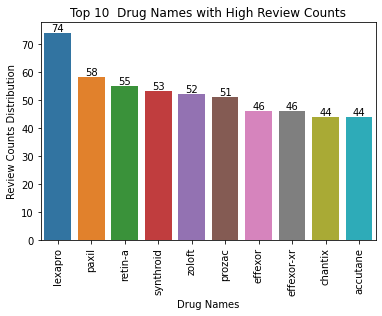

In [25]:
ax=sns.barplot(x=drug_count['Drug Name'][:10],y=drug_count['Number of Records for drugs'][:10])
ax.bar_label(ax.containers[0])
plt.title('Top 10  Drug Names with High Review Counts')
plt.xlabel('Drug Names')
plt.ylabel('Review Counts Distribution')
plt.xticks(rotation = 90);
plt.show()

#### What are the different  health conditions that the drugs are used to treat and how many records are there for each health condition?

In [26]:
 health_conditions_count=data_set.groupby('condition').size().sort_values(ascending=False).to_frame().reset_index().rename(columns={'condition':'Health Condition',0:'Number of Records for Health Condition'})

In [27]:
health_conditions_count

,Health Condition,Number of Records for Health Condition
0,depression,302
1,acne,210
2,anxiety,90
3,insomnia,75
4,birth control,68
...,...,...
1799,gad - generalised anxiety disorder.,1
1800,fybromyalgia,1
1801,fungus on big toes,1
1802,fungus,1


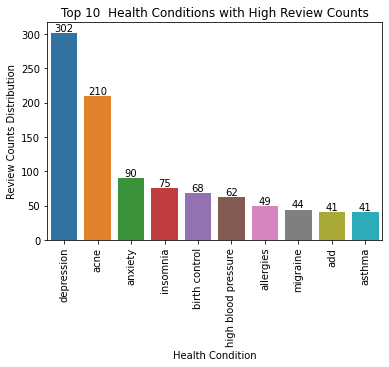

In [28]:
ax=sns.barplot(x=health_conditions_count['Health Condition'][:10],y=health_conditions_count['Number of Records for Health Condition'][:10])
ax.bar_label(ax.containers[0])
plt.title('Top 10  Health Conditions with High Review Counts')
plt.xlabel('Health Condition')
plt.ylabel('Review Counts Distribution')
plt.xticks(rotation = 90);
plt.show()

#### What is the distribution of ratings given by the reviewers for the drugs?

In [29]:
data_set.rating.value_counts().to_frame().reset_index().rename(columns={'index':'rating','rating':'Counts distribution'})

,rating,Counts distribution
0,10,967
1,8,745
2,9,612
3,7,471
4,1,419
5,5,226
6,6,214
7,3,194
8,4,149
9,2,135


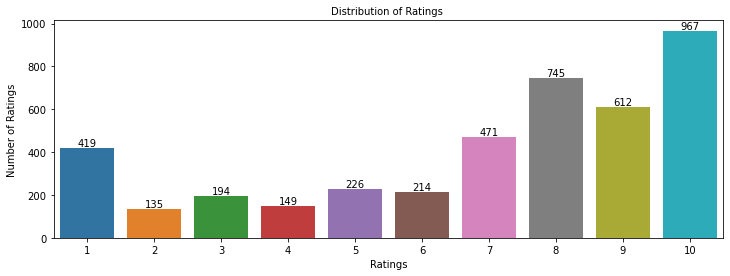

In [30]:
plt.figure(figsize = (12, 4))

ax=sns.countplot(data_set.rating)
ax.bar_label(ax.containers[0])
plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()


####   Which drugs have the highest average rating in the dataset?

In [31]:
average_rating=data_set.groupby('urlDrugName')['rating'].mean().sort_values(ascending=False).to_frame().reset_index().rename(columns={'urlDrugName':'Drug Name','rating':'Average Rating'})

In [32]:
average_rating

,Drug Name,Average Rating
0,nasacort-aq,10.0
1,delestrogen,10.0
2,exelon,10.0
3,neoprofen,10.0
4,qvar,10.0
...,...,...
535,aralen,1.0
536,diltiazem,1.0
537,enablex,1.0
538,ceclor,1.0


In [33]:
av_rating=average_rating['Average Rating'].value_counts().sort_values(ascending=False).to_frame().reset_index().rename(columns={'index':'Average Rating','Average Rating':'Counts Distribution'})[:]

In [34]:
av_rating[:10]

,Average Rating,Counts Distribution
0,10.0,53
1,8.0,49
2,9.0,45
3,7.0,37
4,6.0,26
5,1.0,17
6,5.0,14
7,8.5,12
8,7.5,11
9,4.0,10


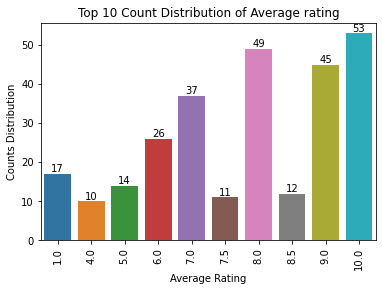

In [35]:
ax=sns.barplot(x=av_rating['Average Rating'][:10],y=av_rating['Counts Distribution'][:10])
ax.bar_label(ax.containers[0])
plt.title('Top 10 Count Distribution of Average rating')
plt.xlabel('Average Rating')
plt.ylabel('Counts Distribution')
plt.xticks(rotation = 90);
plt.show()

#### Is there a health condition in which the same drug interacted with it more than once?

In [36]:
data_set.groupby(['urlDrugName', 'condition']).count()['rating'] > 1

urlDrugName  condition                                        
abilify      bipolar                                               True
             bipolar disorder                                     False
             depression                                            True
             depression not resolved with antidepressant drugs    False
             depression/anxiety                                   False
                                                                  ...  
zyrtec       year round allergies                                  True
zyrtec-d     allergies                                             True
             hay fever                                            False
             pollen, dust, mold and tree allergies                False
zyvox        mrsa                                                 False
Name: rating, Length: 2648, dtype: bool

#### What is the distribution of drug effectiveness given by the reviewers for the drugs?

In [37]:
data_set.effectiveness.value_counts().sort_values(ascending=False).to_frame().reset_index().rename(columns={'index':'Effectiveness','effectiveness':'Counts Distribution'})

,Effectiveness,Counts Distribution
0,Highly Effective,1738
1,Considerably Effective,1235
2,Moderately Effective,570
3,Ineffective,327
4,Marginally Effective,262


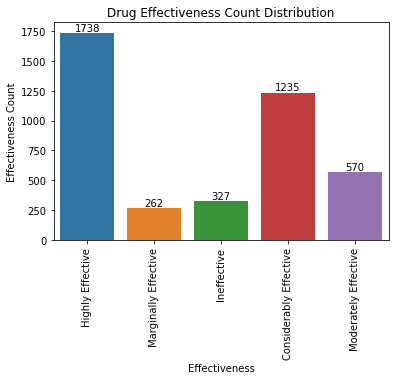

In [38]:
#plot of Channel Count Distribution
ax=sns.countplot(x=data_set['effectiveness'])
ax.bar_label(ax.containers[0])
plt.title('Drug Effectiveness Count Distribution')
plt.xlabel('Effectiveness')
plt.ylabel('Effectiveness Count')
plt.xticks(rotation = 90);
plt.show()

#### What is the distribution of drug side effects given by the reviewers for the drugs?

In [39]:
data_set.sideEffects.value_counts().sort_values(ascending=False).to_frame().reset_index().rename(columns={'index':'Side Effects','sideEffects':'Counts Distribution'})

,Side Effects,Counts Distribution
0,Mild Side Effects,1347
1,No Side Effects,1193
2,Moderate Side Effects,848
3,Severe Side Effects,489
4,Extremely Severe Side Effects,255


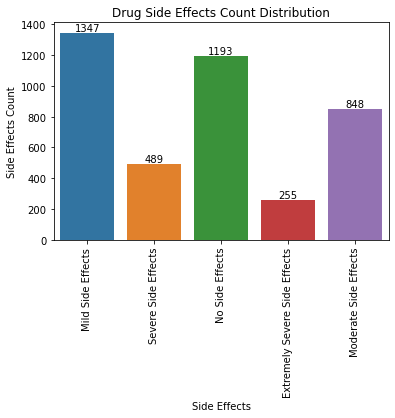

In [40]:
#plot of Channel Count Distribution
ax=sns.countplot(x=data_set['sideEffects'])
ax.bar_label(ax.containers[0])
plt.title('Drug Side Effects Count Distribution')
plt.xlabel('Side Effects')
plt.ylabel('Side Effects Count')
plt.xticks(rotation = 90);
plt.show()

In [41]:
#data_set.groupby(['urlDrugName','effectiveness']).size()

#### TEXT DATA PREPROCESSING

In [42]:
data_set.head(1)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."


In [43]:
text_data_columns=['benefitsReview','sideEffectsReview','commentsReview']

#### Pipeline

- Text cleaning
- Pre-processing
- Feature Engineering
- Modelling
- Evaluation


### Text cleaning

In [44]:
def convert_to_lowercase(x):
    x = x.lower()
    return x

def contract_text(x):
    import contractions
    expanded_text = []   
    for word in x.split():
        expanded_text.append(contractions.fix(word))
    x = ' '.join(expanded_text)
    return x

def remove_punctuations(x):
    x=re.sub('[%s]' % re.escape(string.punctuation), '' , x)
    return x

def remove_digits_in_text(x):
    x=''.join((i for i in x if not i.isdigit()))
    return x
def remove_backslash_in_text(x):
    x=''.join(i for i in x if '\\' not in i )
    return x
def remove_stopwords(x):
    stop_words = set(stopwords.words('english'))
    x = " ".join([word for word in str(x).split() if word not in stop_words])
    return x
def remove_new_lines(x):
    x = re.sub('\n', '', x)
    return x
def cleaned_text_review(x):
    x=''.join(i for i in x )
    return x

In [45]:
def text_cleaning_pipeline(text):
    # convert text to lowercase    
    text = convert_to_lowercase(text)
    # expand  contractions in text
    text = contract_text(text)
    # remove punctuation
    text = remove_punctuations(text)
    # remove digits in text
    text= remove_digits_in_text(text)
    # remove stop words
    text= remove_stopwords(text)
    # remove backslash in text
    text=remove_backslash_in_text(text)
    # remove new lines
    text = remove_new_lines(text)
    # cleaned text review
    text=cleaned_text_review(text)
    return text

In [46]:
# apply text cleaning pipeline on each review in the dataset
for i in text_data_columns:
    data_set[i] = data_set[i].apply(lambda x:text_cleaning_pipeline(x))

### Text Pre-processing

- tokenization
- lemmatization

In [47]:
def tokenize_review(x):
    x = word_tokenize(str(x))
    return x


def lemmatize_words(x):
    lemmatizer = WordNetLemmatizer()
    x = " ".join([lemmatizer.lemmatize(word) for word in x])
    return x

In [48]:
def text_pre_processing_pipeline(text):
    text=tokenize_review(text)
    #text=stem_words(text)
    text=lemmatize_words(text)
    return text

In [49]:
# apply text pre_processing pipeline on each review in the dataset
for i in text_data_columns:
    data_set[i] = data_set[i].apply(lambda x:text_pre_processing_pipeline(x))

### Feature Engineering

In [50]:
sid = SentimentIntensityAnalyzer()

In [51]:
data_set[['Br_Negative', 'Br_Neutral', 'Br_Positive', 'Br_Compound']] = data_set['benefitsReview'].apply(sid.polarity_scores).apply(pd.Series)
data_set[['Se_Negative', 'Se_Neutral', 'Se_Positive', 'Se_Compound']] = data_set['sideEffectsReview'].apply(sid.polarity_scores).apply(pd.Series)
data_set[['Cr_Negative', 'Cr_Neutral', 'Cr_Positive', 'Cr_Compound']] = data_set['commentsReview'].apply(sid.polarity_scores).apply(pd.Series)

In [52]:
round(data_set.Cr_Compound.mean(),3)

0.005

In [53]:
data_set.shape

(4132, 21)

In [54]:
def Sentiment_Classification(x):
    if (x>0):
        x='positive'
    elif (x<0):
        x='negative'
    else:
        x='neutral'
    return x

In [55]:
data_set['Br_Sentiment']=data_set.Br_Compound.apply(lambda x:Sentiment_Classification(x))
data_set['Se_Sentiment']=data_set.Se_Compound.apply(lambda x:Sentiment_Classification(x))
data_set['Cr_Sentiment']=data_set.Cr_Compound.apply(lambda x:Sentiment_Classification(x))

In [56]:
data_set.Br_Sentiment.value_counts()

positive    2027
negative    1563
neutral      542
Name: Br_Sentiment, dtype: int64

In [57]:
data_set.Se_Sentiment.value_counts()

negative    2000
neutral     1252
positive     880
Name: Se_Sentiment, dtype: int64

In [58]:
data_set.Cr_Sentiment.value_counts()

positive    1546
negative    1452
neutral     1134
Name: Cr_Sentiment, dtype: int64

In [59]:
sentiment_dict = {'positive':1,'negative':0,'neutral':2}

In [60]:
data_set['Target']=data_set['Cr_Sentiment'].map(sentiment_dict)

In [61]:
data_set.Target.value_counts()

1    1546
0    1452
2    1134
Name: Target, dtype: int64

In [62]:
data=data_set[['Unnamed: 0','urlDrugName', 'rating', 'effectiveness', 'sideEffects','condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview','Br_Sentiment', 'Se_Sentiment', 'Cr_Sentiment', 'Target']]

In [63]:
data.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,Br_Sentiment,Se_Sentiment,Cr_Sentiment,Target
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed progression left ventricular dysfunctio...,cough hypotension proteinuria impotence renal ...,monitor blood pressure weight ass resolution f...,negative,negative,negative,0
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,although type birth control con pro help cramp...,heavy cycle cramp hot flash fatigue long lasti...,hate birth control would suggest anyone,positive,positive,negative,0
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,used cramp badly would leave balled bed least ...,heavier bleeding clotting normal,took pill onset menstrual cramp every hour too...,negative,neutral,negative,0
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,acid reflux went away month day drug heartburn...,constipation dry mouth mild dizziness would go...,given prilosec prescription dose mg per day me...,negative,negative,neutral,2
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,think lyrica starting help pain sideeffects se...,felt extremely drugged dopey could drive med a...,see,negative,neutral,neutral,2


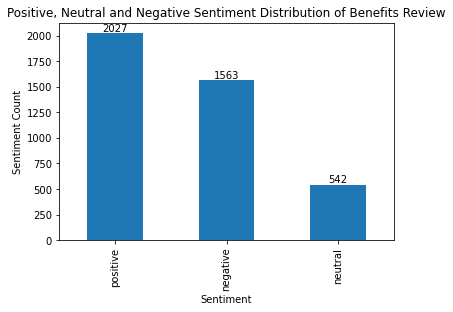

In [64]:
ax=data.Br_Sentiment.value_counts().plot(kind='bar',title="Positive, Neutral and Negative Sentiment Distribution of Benefits Review")
ax.bar_label(ax.containers[0])
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Count')
plt.show()

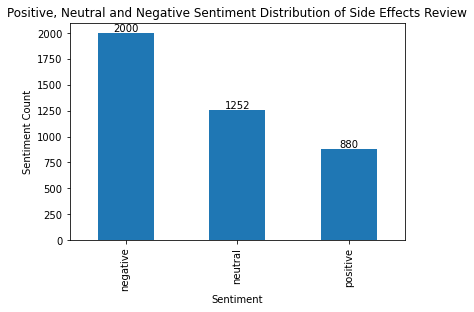

In [65]:
ax=data.Se_Sentiment.value_counts().plot(kind='bar',title="Positive, Neutral and Negative Sentiment Distribution of Side Effects Review")
ax.bar_label(ax.containers[0])
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Count')
plt.show()

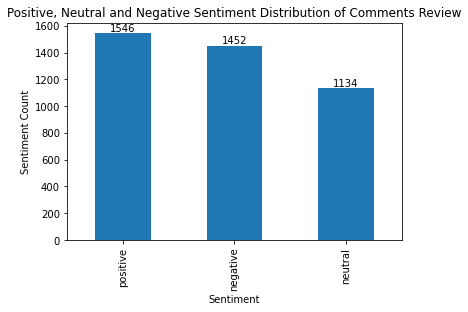

In [66]:
ax=data.Cr_Sentiment.value_counts().plot(kind='bar',title="Positive, Neutral and Negative Sentiment Distribution of Comments Review")
ax.bar_label(ax.containers[0])
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Count')
plt.show()

In [67]:
#positive
text_pos=' '
for i in range(len(data[data.Br_Sentiment=='positive']['benefitsReview'])):
    ps=data[data.Br_Sentiment=='positive']['benefitsReview'].values[i]
    text_pos+=ps

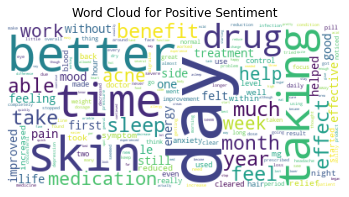

In [68]:
word_cloud=WordCloud(collocations=False,background_color='white').generate(text_pos)
plt.imshow(word_cloud,)
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()

In [69]:
#negative
text_neg=' '
for i in range(len(data[data.Br_Sentiment=='negative']['benefitsReview'])):
    ng=data[data.Br_Sentiment=='negative']['benefitsReview'].values[i]
    text_neg+=ng

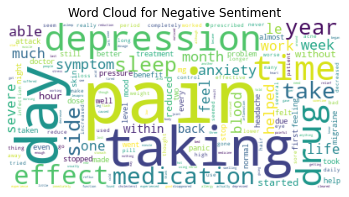

In [70]:
word_cloud=WordCloud(collocations=False,background_color='white').generate(text_neg)
plt.imshow(word_cloud,)
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

In [71]:
#neutral
text_neu=' '
for i in range(len(data[data.Br_Sentiment=='neutral']['benefitsReview'])):
    nu=data[data.Br_Sentiment=='neutral']['benefitsReview'].values[i]
    text_neu+=nu

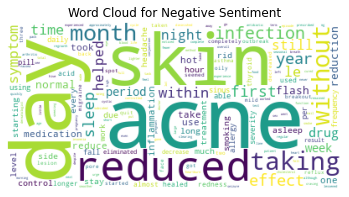

In [72]:
word_cloud=WordCloud(collocations=False,background_color='white').generate(text_neu)
plt.imshow(word_cloud,)
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

In [73]:
data.columns

Index(['Unnamed: 0', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects',
       'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview',
       'Br_Sentiment', 'Se_Sentiment', 'Cr_Sentiment', 'Target'],
      dtype='object')

In [74]:
#positive
text_pos=' '
for i in range(len(data[data.Br_Sentiment=='positive']['sideEffectsReview'])):
    ps=data[data.Br_Sentiment=='positive']['sideEffectsReview'].values[i]
    text_pos+=ps

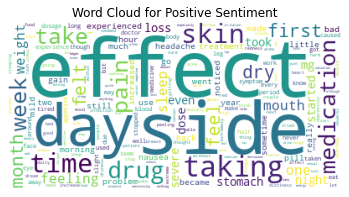

In [75]:
word_cloud=WordCloud(collocations=False,background_color='white').generate(text_pos)
plt.imshow(word_cloud,)
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()

In [76]:
#negative
text_neg=' '
for i in range(len(data[data.Br_Sentiment=='negative']['sideEffectsReview'])):
    ng=data[data.Br_Sentiment=='negative']['sideEffectsReview'].values[i]
    text_neg+=ng

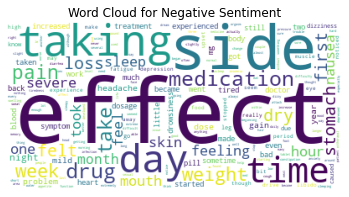

In [77]:
word_cloud=WordCloud(collocations=False,background_color='white').generate(text_neg)
plt.imshow(word_cloud,)
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

In [78]:
#neutral
text_neu=' '
for i in range(len(data[data.Br_Sentiment=='neutral']['sideEffectsReview'])):
    nu=data[data.Br_Sentiment=='neutral']['sideEffectsReview'].values[i]
    text_neu+=nu

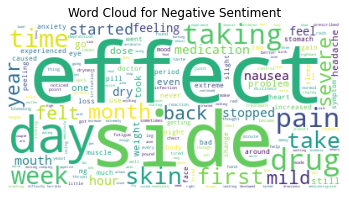

In [79]:
word_cloud=WordCloud(collocations=False,background_color='white').generate(text_neu)
plt.imshow(word_cloud,)
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

In [80]:
#positive
text_pos=' '
for i in range(len(data[data.Br_Sentiment=='positive']['commentsReview'])):
    ps=data[data.Br_Sentiment=='positive']['commentsReview'].values[i]
    text_pos+=ps

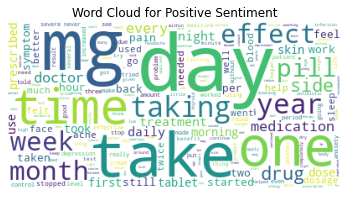

In [81]:
word_cloud=WordCloud(collocations=False,background_color='white').generate(text_pos)
plt.imshow(word_cloud,)
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()

In [82]:
#negative
text_neg=' '
for i in range(len(data[data.Br_Sentiment=='negative']['commentsReview'])):
    ng=data[data.Br_Sentiment=='negative']['commentsReview'].values[i]
    text_neg+=ng

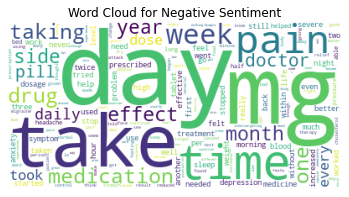

In [83]:
word_cloud=WordCloud(collocations=False,background_color='white').generate(text_neg)
plt.imshow(word_cloud,)
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

In [84]:
#neutral
text_neu=' '
for i in range(len(data[data.Br_Sentiment=='neutral']['benefitsReview'])):
    nu=data[data.Br_Sentiment=='neutral']['benefitsReview'].values[i]
    text_neu+=nu

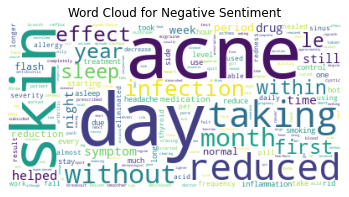

In [85]:
word_cloud=WordCloud(collocations=False,background_color='white').generate(text_neu)
plt.imshow(word_cloud,)
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

## Modelling

In [86]:
len(tr_unique_ID_list),len(ts_unique_ID_list)

(3107, 1036)

In [87]:
data[data['Unnamed: 0'].isin(tr_unique_ID_list)].shape

(3096, 13)

In [88]:
data[data['Unnamed: 0'].isin(ts_unique_ID_list)].shape

(1036, 13)

In [89]:
data_train = data[data['Unnamed: 0'].isin(tr_unique_ID_list)]
data_test=data[data['Unnamed: 0'].isin(ts_unique_ID_list)]

In [90]:
#confussion matrix plot function
def plot_cm(y_test, y_pred,algo, target_names=['negative','positive','neutral'], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title(f'Confusion matrix {algo}')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});

In [91]:
X_train=data_train.commentsReview
X_test =data_test.commentsReview
y_train =data_train.Target
y_test=data_test.Target

In [92]:
print('X_train :', len(X_train))
print('X_test :', len(X_test))
print('y_train :', len(y_train))
print('y_test :', len(y_test))

X_train : 3096
X_test : 1036
y_train : 3096
y_test : 1036


In [93]:
def evaluate_metrics(y_test,y_pred_class):
    from sklearn.metrics import accuracy_score
    result_metrics = [] 
    accuracy = accuracy_score(y_test, y_pred_class)

        #print(f"Accuracy is : {accuracy*100:.1f}%")
        
    result_metrics.append(accuracy)
    
    return result_metrics

## RANDOM FOREST ALGORITHM

In [94]:
tvec= TfidfVectorizer()
rf = RandomForestClassifier(random_state = 42)

In [95]:
model = Pipeline([('vectorizer',tvec),('classifier',rf)])

In [96]:
model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [97]:
predictions=model.predict(X_test)

In [98]:
confusion_matrix(predictions,y_test)

array([[229,  77,  13],
       [ 88, 276,  19],
       [ 40,  58, 236]], dtype=int64)

In [99]:
y_test.value_counts()

1    411
0    357
2    268
Name: Target, dtype: int64

In [100]:
target_names=['negative','positive','neutral']
print(classification_report(y_test, 
                            predictions, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.72      0.64      0.68       357
    positive       0.72      0.67      0.70       411
     neutral       0.71      0.88      0.78       268

    accuracy                           0.72      1036
   macro avg       0.72      0.73      0.72      1036
weighted avg       0.72      0.72      0.71      1036



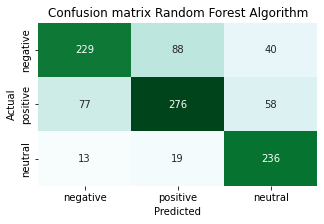

In [101]:
plot_cm(y_test, predictions,'Random Forest Algorithm')

In [102]:
rf_metrics=evaluate_metrics(y_test, predictions)

## NAIVE BAYES ALGORITHIM

In [103]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score


In [104]:
vectorizer = CountVectorizer()
clf = MultinomialNB()

In [105]:
model1 = Pipeline([('vectorizer',tvec),('classifier',clf)])

In [106]:
model1.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

In [107]:
predictions=model1.predict(X_test)

In [108]:
confusion_matrix(predictions,y_test)

array([[243,  90,  50],
       [109, 311,  83],
       [  5,  10, 135]], dtype=int64)

In [109]:
target_names=['negative','positive','neutral']
print(classification_report(y_test, 
                            predictions, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.63      0.68      0.66       357
    positive       0.62      0.76      0.68       411
     neutral       0.90      0.50      0.65       268

    accuracy                           0.67      1036
   macro avg       0.72      0.65      0.66      1036
weighted avg       0.70      0.67      0.66      1036



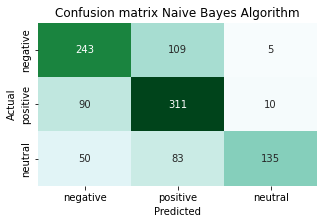

In [110]:
plot_cm(y_test, predictions,'Naive Bayes Algorithm')

In [111]:
nb_metrics=evaluate_metrics(y_test, predictions)

## SUPPORT VECTOR MACHINE 

In [112]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score


In [113]:
clf1 = SVC(kernel='linear')

In [114]:
model2 = Pipeline([('vectorizer',tvec),('classifier',clf1)])

In [115]:
model2.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', SVC(kernel='linear'))])

In [116]:
predictions=model2.predict(X_test)

In [117]:
confusion_matrix(predictions,y_test)

array([[256,  63,  18],
       [ 75, 306,  32],
       [ 26,  42, 218]], dtype=int64)

In [118]:
target_names=['negative','positive','neutral']
print(classification_report(y_test, 
                            predictions, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.76      0.72      0.74       357
    positive       0.74      0.74      0.74       411
     neutral       0.76      0.81      0.79       268

    accuracy                           0.75      1036
   macro avg       0.75      0.76      0.76      1036
weighted avg       0.75      0.75      0.75      1036



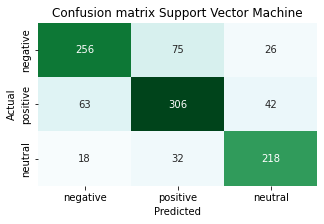

In [119]:
plot_cm(y_test, predictions,'Support Vector Machine')

In [120]:
svm_metrics=evaluate_metrics(y_test, predictions)

## LOGICSTIC  REGRESSION

In [121]:
from sklearn.linear_model import LogisticRegression

In [122]:
lr = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")

In [123]:
model = Pipeline([('vectorizer',tvec),('classifier',lr)])
model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

In [124]:
predictions=model.predict(X_test)

In [125]:
confusion_matrix(predictions,y_test)

array([[244,  57,  12],
       [ 77, 296,  33],
       [ 36,  58, 223]], dtype=int64)

In [126]:
target_names=['negative','positive','neutral']
print(classification_report(y_test, 
                            predictions, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.78      0.68      0.73       357
    positive       0.73      0.72      0.72       411
     neutral       0.70      0.83      0.76       268

    accuracy                           0.74      1036
   macro avg       0.74      0.75      0.74      1036
weighted avg       0.74      0.74      0.74      1036



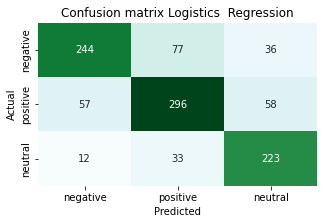

In [127]:
plot_cm(y_test, predictions,'Logistics  Regression')

In [128]:
lr_metrics=evaluate_metrics(y_test, predictions)

## Decision Tree

In [129]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [130]:
dt = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)

In [131]:
model = Pipeline([('vectorizer',tvec),('classifier',dt)])
model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

In [132]:
predictions=model.predict(X_test)

In [133]:
confusion_matrix(predictions,y_test)

array([[159,  99,  11],
       [185, 286, 163],
       [ 13,  26,  94]], dtype=int64)

In [134]:
target_names=['negative','positive','neutral']
print(classification_report(y_test, 
                            predictions, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.59      0.45      0.51       357
    positive       0.45      0.70      0.55       411
     neutral       0.71      0.35      0.47       268

    accuracy                           0.52      1036
   macro avg       0.58      0.50      0.51      1036
weighted avg       0.57      0.52      0.51      1036



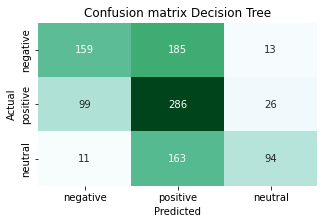

In [135]:
plot_cm(y_test, predictions,'Decision Tree')

In [136]:
dt_metrics_cv=evaluate_metrics(y_test, predictions)

In [137]:
#pip install xgboost

## xgboost

In [138]:
import xgboost as xgb

In [139]:
xgclf = xgb.XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42)

In [140]:
model = Pipeline([('vectorizer',tvec),('classifier',xgclf)])
model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.15,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=1

In [141]:
predictions=model.predict(X_test)

In [142]:
confusion_matrix(predictions,y_test)

array([[254,  61,  12],
       [ 75, 301,  15],
       [ 28,  49, 241]], dtype=int64)

In [143]:
target_names=['negative','positive','neutral']
print(classification_report(y_test, 
                            predictions, 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.78      0.71      0.74       357
    positive       0.77      0.73      0.75       411
     neutral       0.76      0.90      0.82       268

    accuracy                           0.77      1036
   macro avg       0.77      0.78      0.77      1036
weighted avg       0.77      0.77      0.77      1036



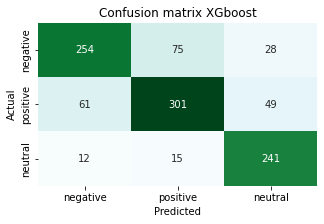

In [144]:
plot_cm(y_test, predictions,'XGboost')

In [145]:
xg_metrics=evaluate_metrics(y_test, predictions)

In [146]:
# Creating a table which contain all the metrics

metrics_table = {'Metric': ['Accuracy'], 
        'Logistic Regression': lr_metrics,
        'Naive Bayes': nb_metrics,
        'Decision Tree': dt_metrics_cv,
         'Random Forrest': rf_metrics,
        'Support Vector Machine': svm_metrics,
        'XG Boost': xg_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Decision Tree','Random Forrest','Support Vector Machine',
                                                    'XG Boost'] )




## Model Accuracy Comparison

In [147]:
df_metrics

,Metric,Logistic Regression,Naive Bayes,Decision Tree,Random Forrest,Support Vector Machine,XG Boost
0,Accuracy,0.736486,0.665058,0.52027,0.715251,0.752896,0.76834


In [148]:
drug_id_dict={drug_count['Drug Name'][k]:k+1 for k in range(len(drug_count['Drug Name']))}

In [149]:
condition_id_dict={health_conditions_count['Health Condition'][i]:i+1 for i in range(len(health_conditions_count['Health Condition']))}

## Mapping drug names  and user health conditions to their unique ids

In [150]:
data_train['drug_id']=data_train.urlDrugName.map(drug_id_dict)
data_train['condition_id']=data_train.condition.map(condition_id_dict)
data_test['drug_id']=data_test.urlDrugName.map(drug_id_dict)
data_test['condition_id']=data_test.condition.map(condition_id_dict)

In [151]:
data_tr=data_train[['condition_id','drug_id','rating','Target']]
data_ts=data_test[['condition_id','drug_id','rating','Target']]

In [152]:
dataset=pd.concat([data_tr,data_ts])

In [153]:
list(drug_id_dict.keys())[list(drug_id_dict.values()).index(6)]

'prozac'

In [154]:
dataset['Drug Name']= dataset['drug_id'].apply(lambda x: list(drug_id_dict.keys())[list(drug_id_dict.values()).index(x)])

In [155]:
dataset['User Health Condition']= dataset['condition_id'].apply(lambda x: list(condition_id_dict.keys())[list(condition_id_dict.values()).index(x)])

In [156]:
dataset.head()

,condition_id,drug_id,rating,Target,Drug Name,User Health Condition
0,357,351,4,0,enalapril,management of congestive heart failure
1,1078,58,1,0,ortho-tri-cyclen,birth prevention
2,262,263,10,0,ponstel,menstrual cramps
3,12,43,3,2,prilosec,acid reflux
4,18,31,2,2,lyrica,fibromyalgia


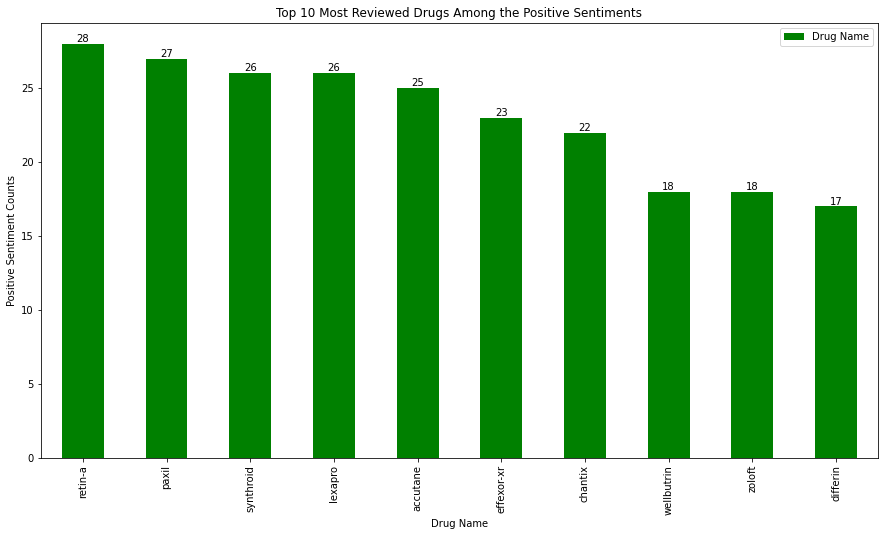

In [157]:
# Filter the top 10 most used drugs among the positive sentiments
ax=dataset[dataset['Target']==1].groupby('Drug Name')['Drug Name'].count().sort_values(ascending=False)[:10].to_frame().plot(kind='bar',figsize=(15,8),color='g')
ax.bar_label(ax.containers[0])
plt.title('Top 10 Most Reviewed Drugs Among the Positive Sentiments')
plt.xlabel('Drug Name')
plt.ylabel('Positive Sentiment Counts')
plt.show()

In [158]:
# dataset[dataset['Target']==1].groupby('Drug Name')['Drug Name'].count().sort_values(ascending=False)[:10].to_frame().plot(kind='bar',figsize=(15,8),color='g')


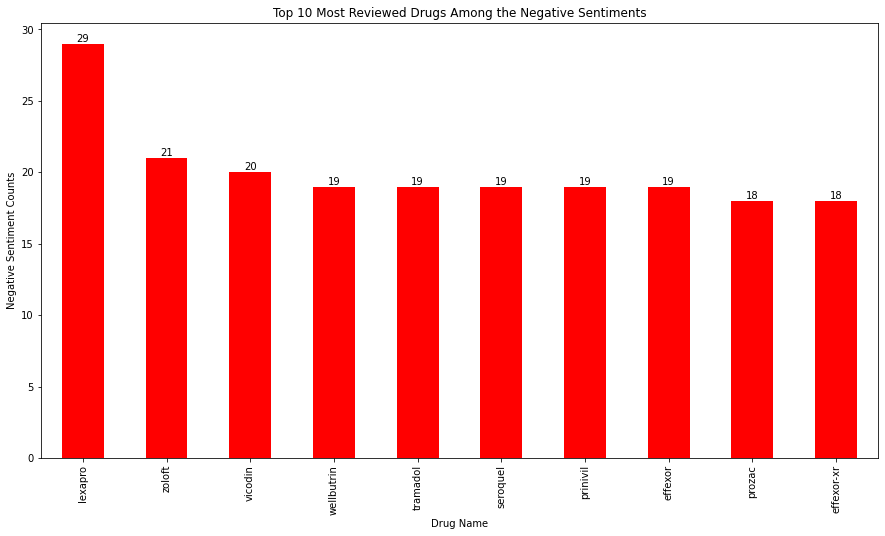

In [159]:
# Filter the top 10 most used drugs among the negative sentiments
ax=dataset[dataset['Target']==0].groupby('Drug Name')['Drug Name'].count().sort_values(ascending=False)[:10].plot(kind='bar',figsize=(15,8),color='r')
ax.bar_label(ax.containers[0])
plt.title('Top 10 Most Reviewed Drugs Among the Negative Sentiments')
plt.xlabel('Drug Name')
plt.ylabel('Negative Sentiment Counts')
plt.show()

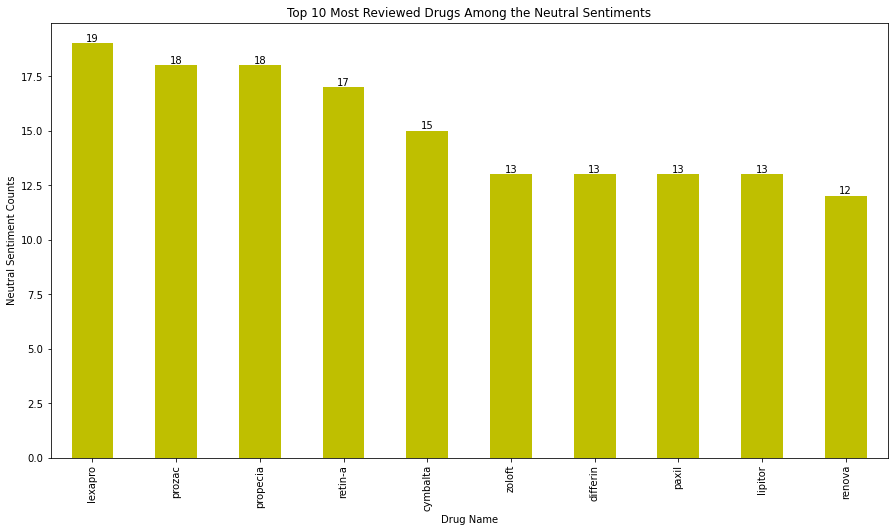

In [160]:
# Filter the top 10 most used drugs among the neutral sentiments
ax=dataset[dataset['Target']==2].groupby('Drug Name')['Drug Name'].count().sort_values(ascending=False)[:10].plot(kind='bar',figsize=(15,8),color='y')
ax.bar_label(ax.containers[0])
plt.title('Top 10 Most Reviewed Drugs Among the Neutral Sentiments')
plt.xlabel('Drug Name')
plt.ylabel('Neutral Sentiment Counts')
plt.show()

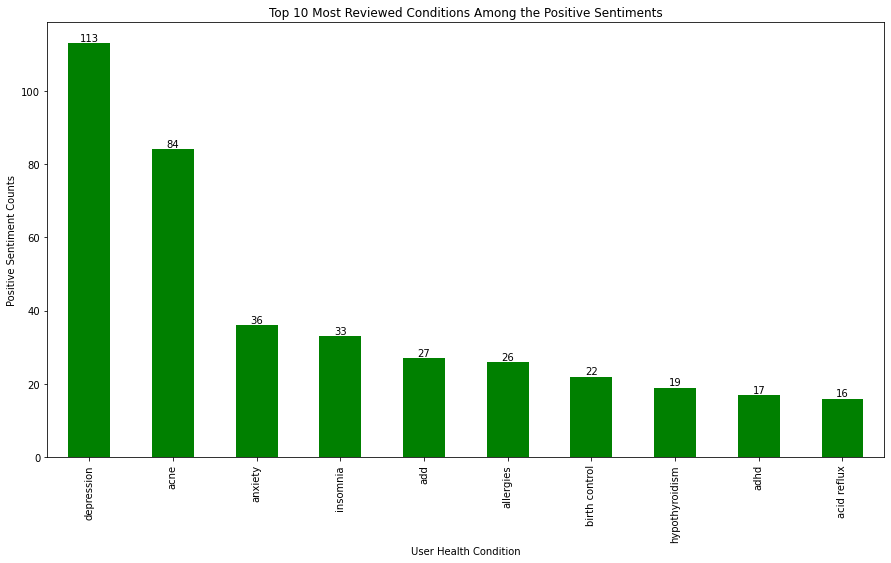

In [161]:
# Filter the top 10 most occurred conditions among the positive sentiments
ax=dataset[dataset['Target']==1].groupby('User Health Condition')['User Health Condition'].count().sort_values(ascending=False)[:10].plot(kind='bar',figsize=(15,8),color='g')
ax.bar_label(ax.containers[0])
plt.title('Top 10 Most Reviewed Conditions Among the Positive Sentiments')
plt.xlabel('User Health Condition')
plt.ylabel('Positive Sentiment Counts')
plt.show()

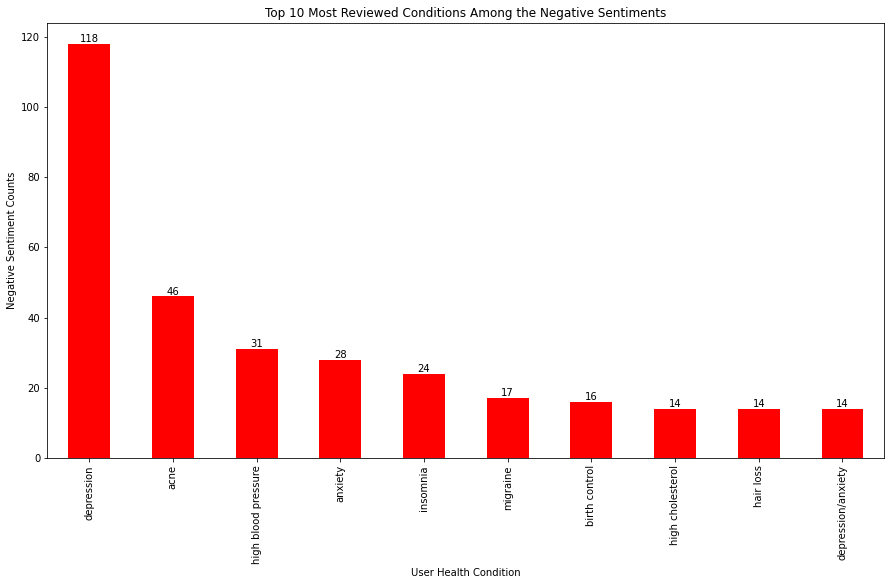

In [162]:
# Filter the top 10 most occurred conditions among the negative sentiments
ax=dataset[dataset['Target']==0].groupby('User Health Condition')['User Health Condition'].count().sort_values(ascending=False)[:10].plot(kind='bar',figsize=(15,8),color='r')
ax.bar_label(ax.containers[0])
plt.title('Top 10 Most Reviewed Conditions Among the Negative Sentiments')
plt.xlabel('User Health Condition')
plt.ylabel('Negative Sentiment Counts')
plt.show()

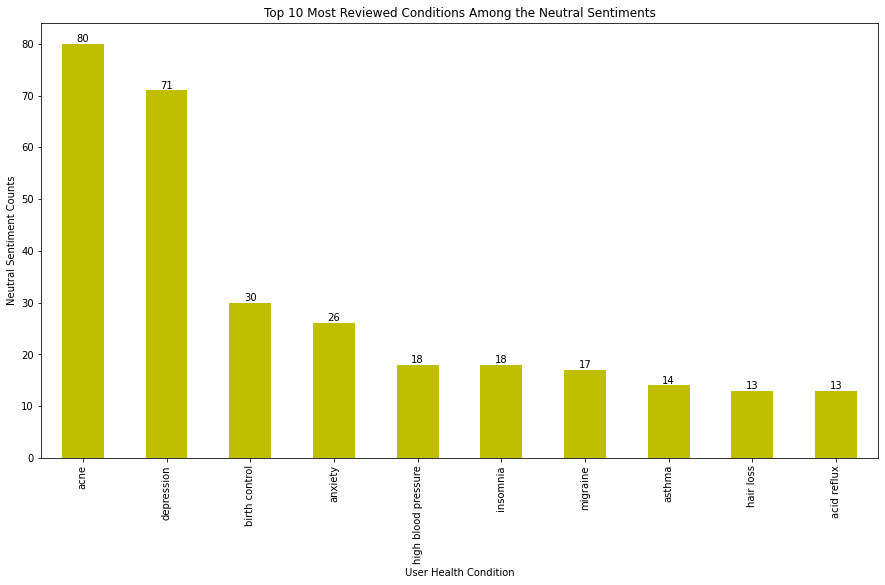

In [163]:
# Filter the top 10 most occurred conditions among the neutral sentiments
ax=dataset[dataset['Target']==2].groupby('User Health Condition')['User Health Condition'].count().sort_values(ascending=False)[:10].plot(kind='bar',figsize=(15,8),color='y')
ax.bar_label(ax.containers[0])
plt.title('Top 10 Most Reviewed Conditions Among the Neutral Sentiments')
plt.xlabel('User Health Condition')
plt.ylabel('Neutral Sentiment Counts')
plt.show()

## Preparing data for recommendation system

In [164]:
# Calculating average ratings
mean_rating = dataset.groupby('drug_id')['rating'].mean()
# Calculating the count of ratings
rating_count = dataset.groupby('drug_id')['rating'].count()

# Making a dataframe with the count and average of ratings
rating = pd.DataFrame({'avg_rating':mean_rating, 'rating_count':rating_count})

In [165]:
rating

,avg_rating,rating_count
drug_id,,
1,6.891892,74
2,6.431034,58
3,7.545455,55
4,7.867925,53
5,7.557692,52
...,...,...
536,8.000000,1
537,8.000000,1
538,9.000000,1


## Rank base recommendation system

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user condition  into the system and the machine is not able to recommend drugs to the new user condition, as the new user condition did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend drugs to the new user condition.

In [166]:
def top_n_drugs(data, n, min_interaction=10):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] >= min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    recommendations = pd.DataFrame(recommendations).reset_index()
    recommendations.drug_id=recommendations.drug_id.apply(lambda y: list(filter(lambda x: drug_id_dict[x]==y,drug_id_dict))[0])
    recommendations.rename(columns={'drug_id':'Drug Name'},inplace=True)
    return recommendations[:n]

In [167]:
top_n_drugs(rating,15,min_interaction = 10)

,Drug Name,avg_rating,rating_count
0,maxalt,9.400000,10
1,armour-thyroid,9.214286,14
2,vivelle-dot,9.090909,11
3,valium,9.000000,12
4,acyclovir,9.000000,12
5,alprazolam,8.769231,13
6,zovirax,8.750000,12
7,valtrex,8.678571,28
8,meridia,8.500000,16
9,enbrel,8.428571,14


## CORRELATION  AND CHI SQAURE TEST

In [168]:
dataset.head(1)

,condition_id,drug_id,rating,Target,Drug Name,User Health Condition
0,357,351,4,0,enalapril,management of congestive heart failure


In [169]:
sentiment_class_dict = {1:'positive',0:'negative',2:'neutral'}

In [170]:
dataset['Sentiment Class']=dataset['Target'].map(sentiment_class_dict)

In [171]:
crosstab_result=pd.crosstab(index=dataset.rating, columns=dataset['Sentiment Class'])

In [172]:
print(crosstab_result)

Sentiment Class  negative  neutral  positive
rating                                      
1                     197      110       112
2                      61       23        51
3                      81       57        56
4                      56       40        53
5                      84       64        78
6                      80       51        83
7                     162      115       194
8                     232      230       283
9                     203      153       256
10                    296      291       380


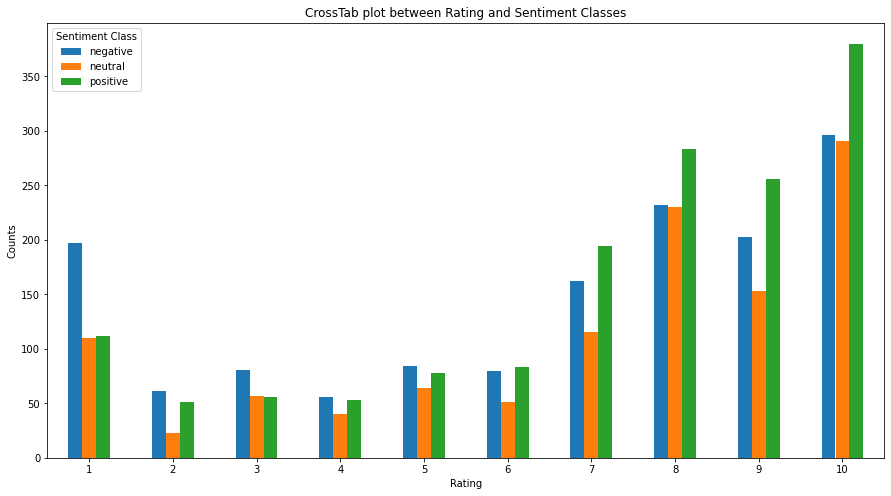

In [196]:
crosstab_result.plot.bar(figsize=(15,8), rot = 0)
plt.title('CrossTab plot between Rating and Sentiment Classes')
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.show()

## Correlation
- **There is pattern in increasing number of positive sentiments as the rating value inreases above value of 5**
- **There is pattern in increasing number of negative sentiments as the rating value decreases below value of 5**
- **Question is: is rating of drugs and sentiment of drug reviews having any significant relationship ?**

## Hypothesis testing Using Chi-Square and p-value

- **Null Hypothesis: There is no any significant relationship between Ratings and Sentiments of reviews**
- **Alternate Hypothesis: There is a significant relationship between Ratings and Sentiments of reviews**
- **Decision Factor: When p-value < 0.05 we fail to accept the null hypothesis**

In [174]:
from scipy.stats import chi2_contingency

In [175]:
chi2_result= chi2_contingency(crosstab_result)

In [176]:
print('The p-value of the chisq test is ', chi2_result[1] )

The p-value of the chisq test is  1.7041954663678825e-08


In [177]:
chi2_result[1] <0.05

True

- Since the p-value is less 0.05, we fail to accept the null hypothesis, therefore There is a significant relationship between Ratings and Sentiments of reviews

## RECOMMENDATION SYSTEM BASE ON COLLABORATIVE FILTERING TECHNIQUES

In [178]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 9))

# Loading the rating dataset
data = Dataset.load_from_df(dataset[['condition_id', 'drug_id', 'rating']], reader)
# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=0)

## User based Collaborative Filtering Recommendation System

In [179]:
# Defining Nearest neighbour algorithm
sim_options = {'name': 'cosine', 'user_based': True}
algo_knn_user = KNNBasic(sim_options=sim_options)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.9093


2.9092995183116153

## Item based Collaborative Filtering Recommendation System 

In [180]:
# Definfing similarity measure
sim_options = {'name': 'cosine', 'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=True)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.9408


2.940806116280083

## Model Based Collaborative Filtering - Matrix Factorization using SVD

In [181]:
#Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 2.8705


2.8705236274532164

## Hyperparameter Tuning for SVD Algorithm

In [182]:
from surprise.model_selection import GridSearchCV
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

2.901013623465411
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}


In [183]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs = 20, lr_all = 0.005, reg_all = 0.6)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 2.8392


2.83924783888803

## Model Evaluation for collaborative filtering techniques

## **Precision and Recall @ k**

RMSE is not the only metric utilized here. Two fundamental measures are also examine here, i.e precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

**Precision@k** - It is the **fraction of recommended drugs that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user health condition.  

**Recall@k** - It is the **fraction of relevant drugs that are recommended to the user in `top k` predictions**.

**Recall** - It is the **fraction of actually relevant drugs that are recommended to the user** i.e. if out of 10 relevant drugs, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision** - It is the **fraction of recommended drugs that are relevant actually** i.e. if out of 10 recommended drugs, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.


In [184]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [185]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10, 15]

# Remove _______ and complete the code
# Make list of models
models = [algo_knn_user,algo_svd,svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
-----> Precision:  0.807
-----> Recall:  0.808
> k=5, model=SVD
-----> Precision:  0.81
-----> Recall:  0.815
> k=5, model=SVD
-----> Precision:  0.81
-----> Recall:  0.815
> k=10, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
-----> Precision:  0.8

In [186]:
def get_recommendations(data, condition_id, top_n, algo):
    
     # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot_table(index='condition_id', columns='drug_id', values='rating', aggfunc='mean')
    
    # Extracting those drugs ids which the user_health_condition_id has already interacted with
    interacted_drugs = user_item_interactions_matrix.loc[condition_id][user_item_interactions_matrix.loc[condition_id].isnull()==False].index.tolist()
    
    # Looping through each of the drug id which user_health_condition_id has  interacted with
    for drug_id in interacted_drugs:
        
        # Predicting the ratings for those interacted drug ids by this user_health_condition_id
        est = algo.predict(condition_id, drug_id).est
        
        # Appending the predicted ratings
        recommendations.append((drug_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)
    recommendations=pd.DataFrame(recommendations,columns=['drug_id','predicted_rating'])
    recommendations.drug_id=recommendations.drug_id.apply(lambda y: list(filter(lambda x: drug_id_dict[x]==y,drug_id_dict))[0])

    return recommendations[:top_n] # returing top n highest predicted rating drugs for this user's health condition

## SENTIMENT-ENHANCED RECOMMENDATION SYSTEM

In [187]:
def get_sent_recommendations(data, condition_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot_table(index='condition_id', columns='drug_id', values='rating', aggfunc='mean')
    
    # Extracting those drugs ids which the user_health_condition_id has already interacted with
    interacted_drugs = user_item_interactions_matrix.loc[condition_id][user_item_interactions_matrix.loc[condition_id].isnull()==False].index.tolist()
    
    # Looping through each of the drug id which user_health_condition_id has  interacted with
    for drug_id in interacted_drugs:
        
        # Predicting the ratings for those interacted drug ids by this user_health_condition_id
        est = algo.predict(condition_id, drug_id).est
        
        # Appending the predicted ratings
        recommendations.append((drug_id, est))
    recommended_drugs_ids=[]
    recommended_rating=[]
    for i in range(len(recommendations)):
        drg_id=recommendations[i][0]
        recom_rate=recommendations[i][1]
        recommended_drugs_ids.append(drg_id)
        recommended_rating.append(recom_rate)
    drg_recom_dataset=dataset[dataset.drug_id.isin(recommended_drugs_ids)]
    df = drg_recom_dataset[['drug_id','Target']]
    df_grouped = df.groupby('drug_id', as_index=False).count()
    df_grouped["positive_count"] = df_grouped.drug_id.apply(lambda x: df[(df.drug_id==x) & (df.Target==1)]["Target"].count())
    df_grouped["negative_count"] = df_grouped.drug_id.apply(lambda x: df[(df.drug_id==x) & (df.Target==0)]["Target"].count())
    df_grouped["neutral_count"] = df_grouped.drug_id.apply(lambda x: df[(df.drug_id==x) & (df.Target==2)]["Target"].count())
    df_grouped["total_review_count"] = df_grouped['Target']
    df_grouped['positive_sentiment_percent'] = np.round(df_grouped["positive_count"]/df_grouped["total_review_count"]*100,2)
    df_grouped['negative_sentiment_percent'] = np.round(df_grouped["negative_count"]/df_grouped["total_review_count"]*100,2)
    df_grouped['neutral_sentiment_percent'] = np.round(df_grouped["neutral_count"]/df_grouped["total_review_count"]*100,2)
    avg_rating_df=drg_recom_dataset.groupby('drug_id')['rating'].mean().sort_values(ascending=False).to_frame().reset_index().rename(columns={'drug_id':'drug_id','rating':'average_rating'})
    drug_predicted_ratings_df=pd.DataFrame(recommendations,columns=['drug_id','predicted_rating'])
    recommendation_df=df_grouped.merge(avg_rating_df,on='drug_id',how='inner')
    recommendation_df=recommendation_df.merge(drug_predicted_ratings_df,on='drug_id',how='inner')
    recommendation_df['rating_difference']=recommendation_df.average_rating-recommendation_df.predicted_rating
    recommendation_df=recommendation_df.sort_values(by=['positive_sentiment_percent'],ascending = False)
    recommendation_df.drug_id=recommendation_df.drug_id.apply(lambda y: list(filter(lambda x: drug_id_dict[x]==y,drug_id_dict))[0])
    recommender_df=recommendation_df[['drug_id','positive_sentiment_percent','negative_sentiment_percent','neutral_sentiment_percent','predicted_rating','average_rating']]
    recommender_df.rename(columns={'drug_id':'Drug Name','positive_sentiment_percent':'Percentage of Positive Sentiment','negative_sentiment_percent':'Percentage of Negative Sentiment','neutral_sentiment_percent':'Percentage of Neutral Sentiment','predicted_rating':'Predicted Drug Average Rating','average_rating':'Actual Drug Average Rating'}, inplace=True)
    #print(f'The top {top_n} recommended drugs for {list(condition_id_dict.keys())[list(condition_id_dict.values()).index(condition_id)]} with their sentiment and rating description is given below:')
    return recommender_df [:top_n].reset_index(drop=True)
    

In [188]:
def plot_recommended_drugs_sentiment_analytics(df,condition_id):
    df=df.iloc[:,:4]
    df.set_index('Drug Name').plot(kind='bar', figsize=(15,8))
    plt.title(f'Sentiment Analytics of recommended drugs for {list(condition_id_dict.keys())[list(condition_id_dict.values()).index(condition_id)]} health condition')
    plt.xlabel('Drug Names')
    plt.ylabel('Sentiment Percentages')
    plt.show()

In [189]:
def plot_recommended_drugs_rating_analytics(df,condition_id):
    df.set_index('Drug Name').iloc[:,-2:].plot(kind='bar', figsize=(15,8))
    plt.title(f'Rating Analytics of recommended drugs for {list(condition_id_dict.keys())[list(condition_id_dict.values()).index(condition_id)]} health condition')
    plt.xlabel('Drug Names')
    plt.ylabel('rating')
    plt.show()

## Getting top 5 sentiment enhanced drug recommendations for anxiety health condition with condition id 3

In [190]:
get_recommendations(dataset, 1,5, svd_algo_optimized)

,drug_id,predicted_rating
0,wellbutrin-xl,7.650913
1,adderall,7.609008
2,wellbutrin-sr,7.489094
3,ritalin,7.352112
4,sarafem,7.329140


In [191]:
df=get_sent_recommendations(dataset,1,10,svd_algo_optimized)

In [192]:
df

,Drug Name,Percentage of Positive Sentiment,Percentage of Negative Sentiment,Percentage of Neutral Sentiment,Predicted Drug Average Rating,Actual Drug Average Rating
0,emsam,75.00,25.00,0.00,6.471017,7.000000
1,ritalin,72.73,27.27,0.00,7.352112,8.090909
2,paxil-cr,71.43,28.57,0.00,6.914871,6.714286
3,adderall,52.17,30.43,17.39,7.609008,8.260870
4,pamelor,50.00,0.00,50.00,6.859330,7.000000
5,effexor-xr,50.00,39.13,10.87,6.850790,6.456522
6,celexa,47.83,26.09,26.09,6.669079,6.956522
7,paxil,46.55,31.03,22.41,6.261410,6.431034
8,sarafem,46.15,46.15,7.69,7.329140,7.769231
9,wellbutrin,42.86,45.24,11.90,7.208393,7.190476


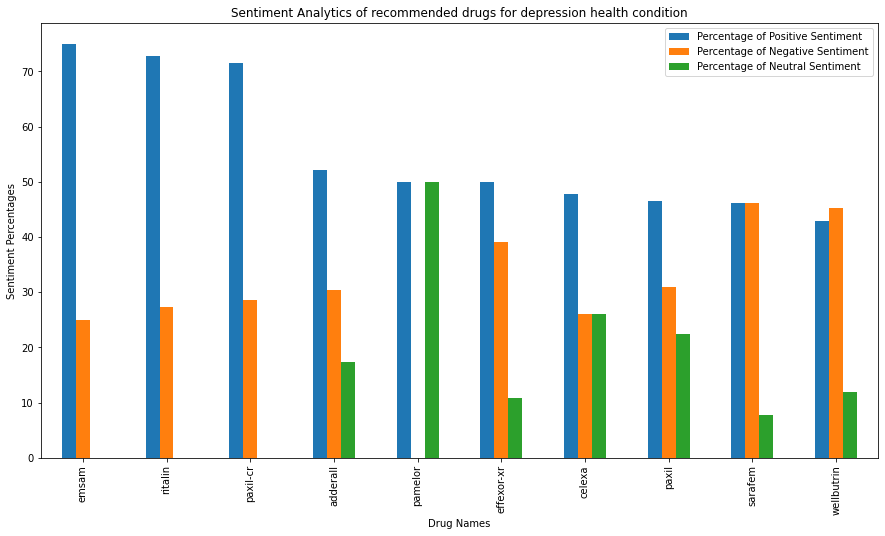

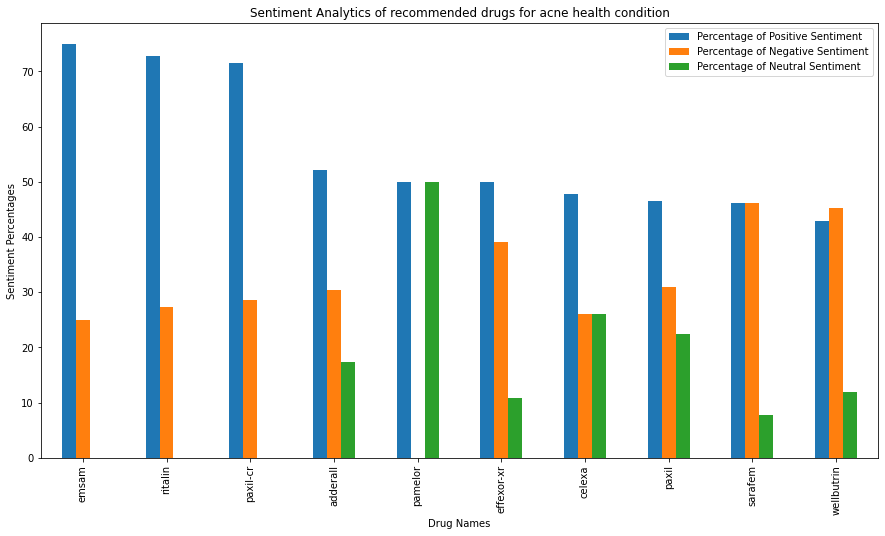

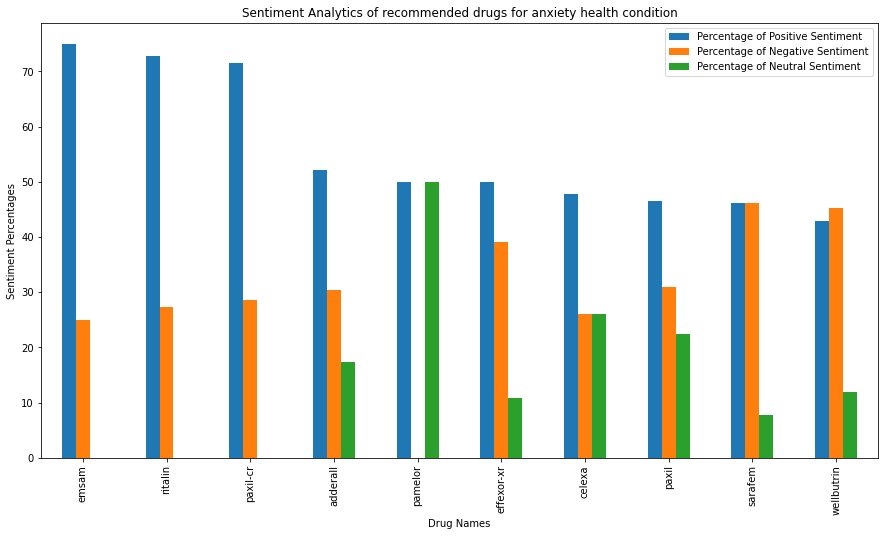

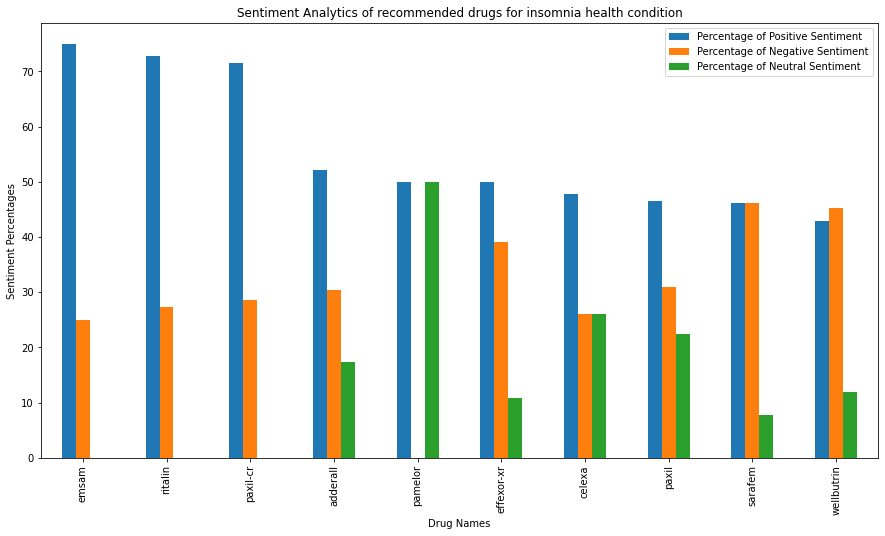

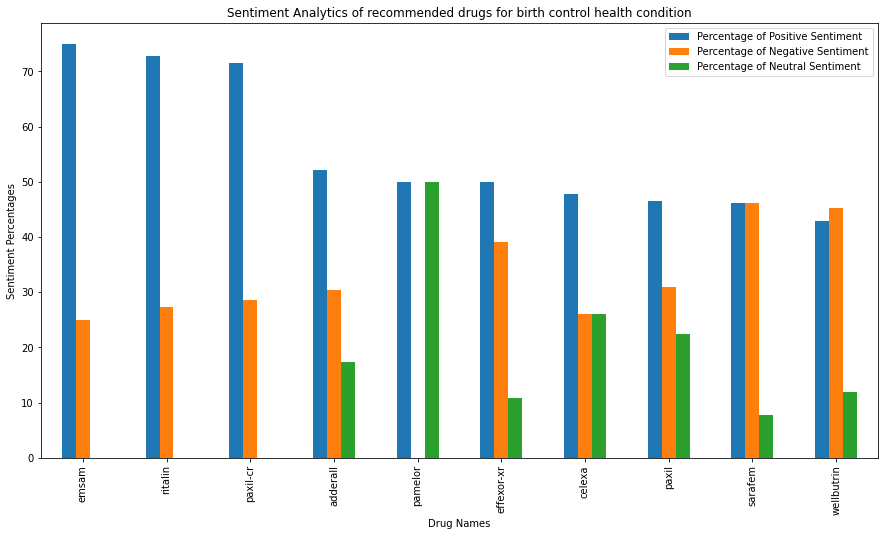

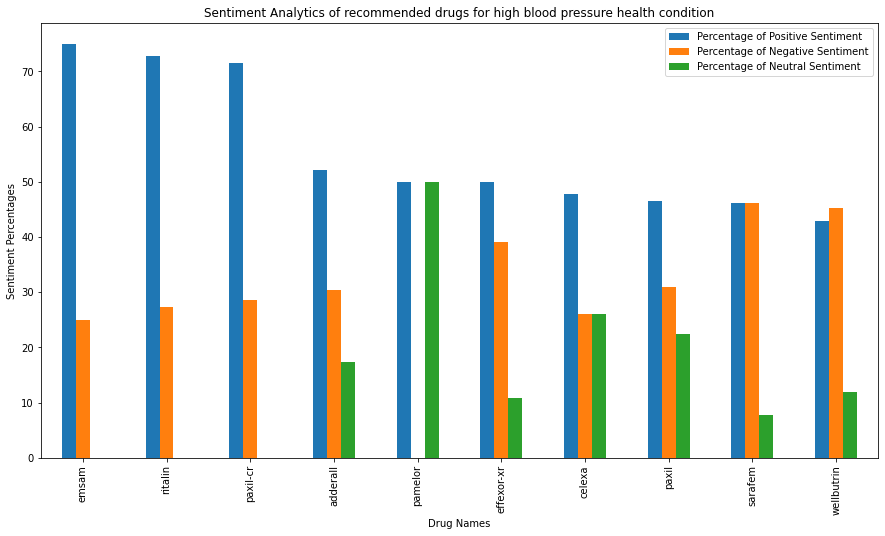

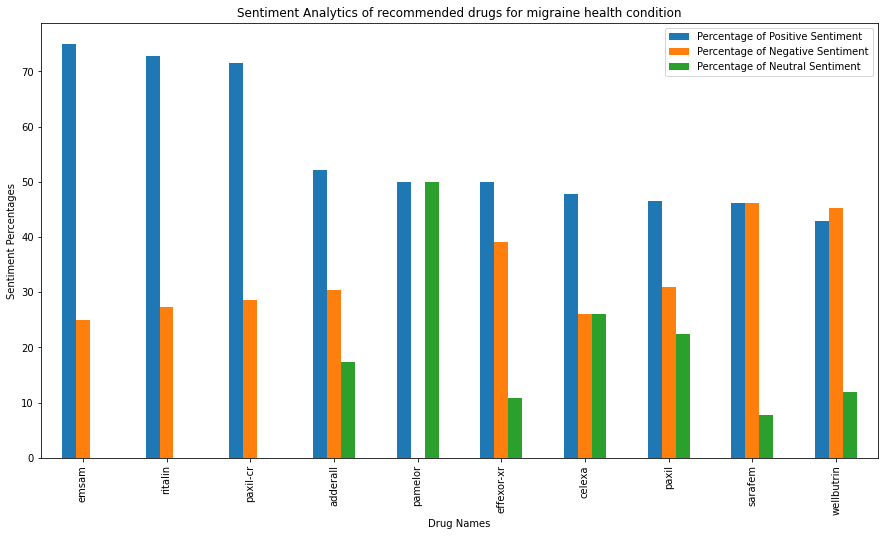

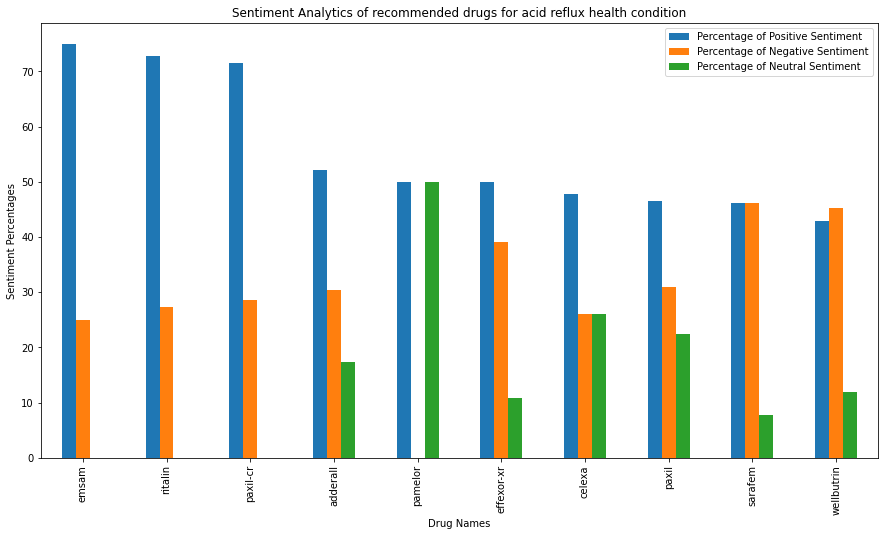

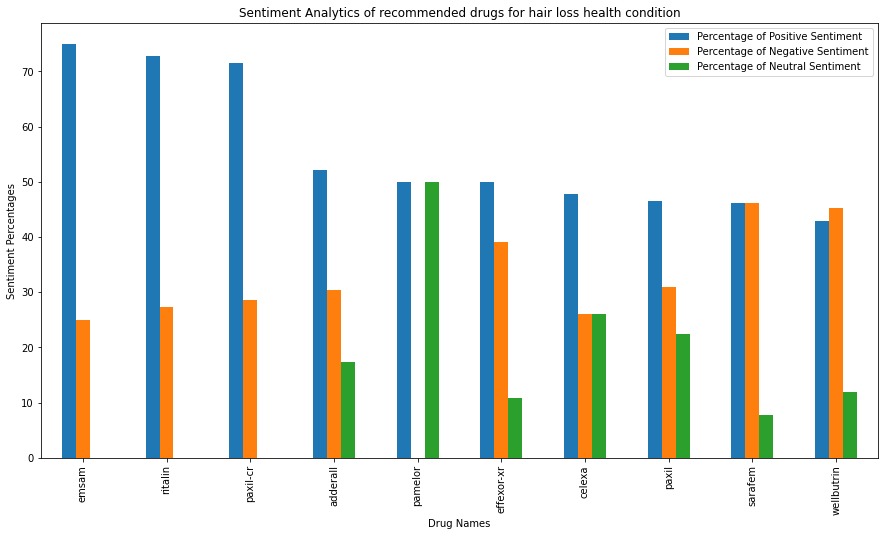

In [193]:
selected_conditions_id=[1,2,3,4,5,6,8,12,15]
for i in selected_conditions_id:
    plot_recommended_drugs_sentiment_analytics(df,i)

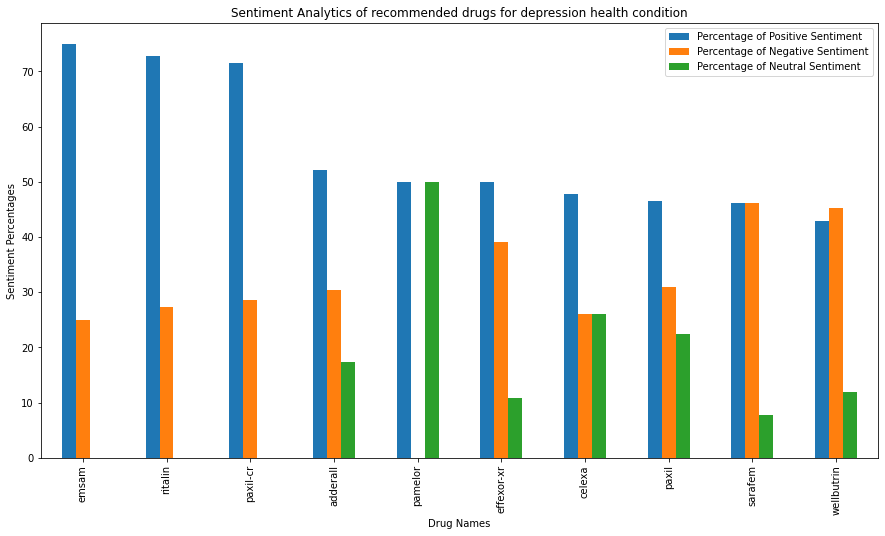

In [194]:
plot_recommended_drugs_sentiment_analytics(df,1)

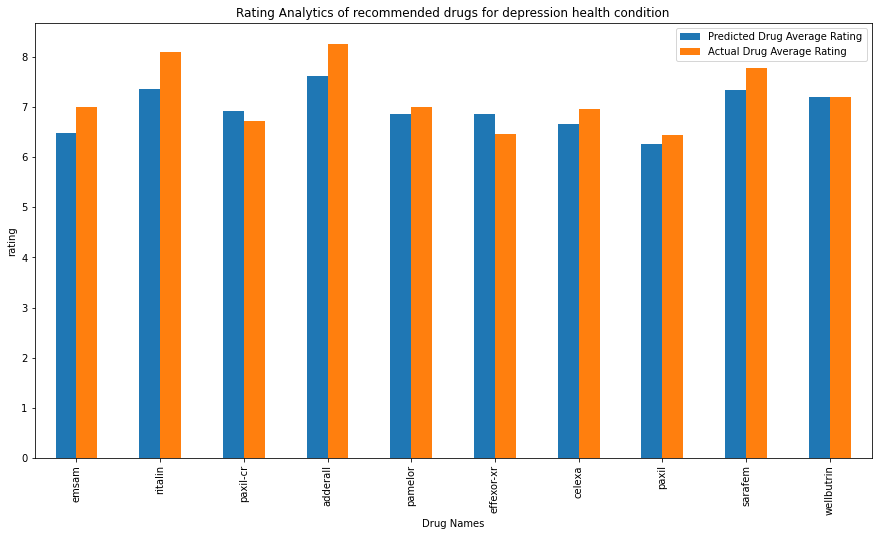

In [195]:
plot_recommended_drugs_rating_analytics(df,1)